<a href="https://colab.research.google.com/github/vifirsanova/spbu-mathling/blob/main/Transformer_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Туториал подготовила Виктория Фирсанова
специально для СПбГУ

# Практика

*   Токенизация с помощью **Byte Pair Encoding**
*   Как работает **Attention Mask**
*   **Конфигурация** модели Transformer
*   Головы внимания и другие **настройки**
*   **Производительность** Transformer в цифрах

## Токенизация с помощью Byte Pair Encoding

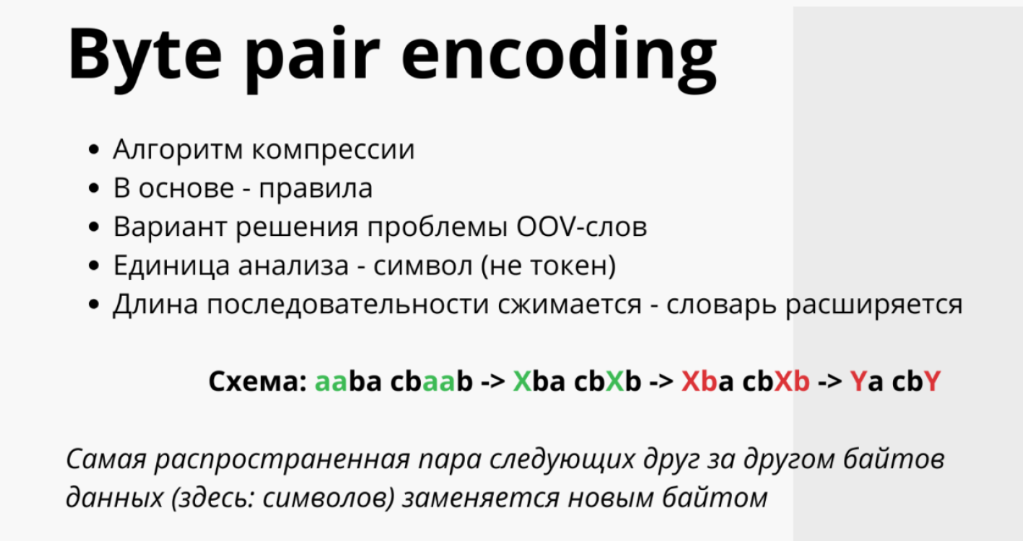

In [ ]:
!pip install sentencepiece

In [ ]:
import sentencepiece as spm

# https://www.kaggle.com/datasets/adarshpathak/shakespeare-text
# путь к данным
input_file = "text.txt"
output_model_prefix = "my_model"

# обучаем модель SentencePiece
spm.SentencePieceTrainer.train(
    f'--input={input_file} --model_prefix={output_model_prefix}'
)

In [ ]:
# загружаем модель
sp = spm.SentencePieceProcessor()
sp.load(f'{output_model_prefix}.model')

# токенизируем текст
text = "Hello, how are you?"
tokens = sp.encode(text, out_type=str)
print("Tokens:", tokens)

Tokens: ['▁He', 'll', 'o', ',', '▁how', '▁are', '▁you', '?']


In [ ]:
decoded_text = sp.decode(tokens)
print("Decoded Text:", decoded_text)

Decoded Text: Hello, how are you?


## Как работает Attention Mask

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

sequence_a = "This is a short sequence."
sequence_b = "This is a rather long sequence. It is at least longer than the sequence A."

encoded_sequence_a = tokenizer(sequence_a)["input_ids"]
encoded_sequence_b = tokenizer(sequence_b)["input_ids"]

In [ ]:
padded_sequences = tokenizer([sequence_a, sequence_b], padding=True)
print(padded_sequences["input_ids"])
print(padded_sequences["attention_mask"])

[[101, 1188, 1110, 170, 1603, 4954, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1188, 1110, 170, 1897, 1263, 4954, 119, 1135, 1110, 1120, 1655, 2039, 1190, 1103, 4954, 138, 119, 102]]
[[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


## Конфигурация модели Transformer

In [ ]:
from transformers import AutoConfig

config = AutoConfig.from_pretrained('bert-base-uncased')

print(config)

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.34.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



## Головы внимания и другие настройки

In [ ]:
from transformers import BertConfig, AutoModelForSequenceClassification

custom_config = BertConfig.from_pretrained('bert-base-uncased')  # default
custom_config.num_attention_heads = 8  # количество голов внимания = 8

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', config=custom_config)
print(model.config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.34.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



## Производительность Transformer в цифрах

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

dataset = load_dataset("glue", "mrpc")  # dataset, task

In [ ]:
import torch

def evaluate_model(model, tokenizer, dataset):
    results = []

    for example in dataset["test"]:
        inputs = tokenizer(example["sentence1"], example["sentence2"], return_tensors="pt", padding=True, truncation=True)
        labels = torch.tensor([example["label"]])

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits

        predictions = torch.argmax(logits, dim=1)
        correct = torch.sum(predictions == labels).item()
        accuracy = correct / len(predictions)
        results.append(accuracy)

    return sum(results) / len(results)

In [ ]:
accuracy = evaluate_model(model, tokenizer, dataset)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 33.51%


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased')
accuracy = evaluate_model(model, tokenizer, dataset)
print(f"Accuracy: {accuracy:.2%}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 66.49%


(с) В. И. Фирсанова

vifirsanova@github.com